# Preprocessing for DE analysis

In [58]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *
from scipy import sparse
import genomic_features as gf

## Merge pseudobulk objects

In [2]:
path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis'
dir_list = pd.read_csv(os.path.join(path, 'experiment_info.csv'))
lane_cols_for_eff = [c for c in dir_list.columns]
run = []
for _, row in dir_list[lane_cols_for_eff].iterrows():
    for col in lane_cols_for_eff:
       run.append(f'{row[col]}_{col}')

In [3]:
# Find all pseudobulk files
pseudobulk_files = []
for i in run:
    pbulk_pattern = glob.glob(os.path.join(path, i, "*_DE_pseudobulk.h5ad"))[0]
    pseudobulk_files.append(pbulk_pattern)

In [4]:
from tqdm.notebook import tqdm

def merge_pseudobulks(h5ad_files, sample_cols = ['lane_id', 'guide_id']):
    # Get var table for all genes
    all_vars = [anndata.experimental.read_lazy(a).var.to_memory().copy() for a in h5ad_files]
    var_merged = pd.concat(all_vars)[['gene_ids', 'gene_name']].drop_duplicates()

    # Read and sum pseudobulks
    merged_adata = sc.read_h5ad(h5ad_files[0])
    merged_adata.obs["sample_id"] = merged_adata.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
    n_cells_merged = merged_adata.obs[['sample_id', 'n_cells']].set_index('sample_id')

    for f in tqdm(h5ad_files[1:], desc="Merging pseudobulk files"):
        a = sc.read_h5ad(f)
        a.obs["sample_id"] = a.obs[sample_cols].apply(lambda x: "_".join(x), axis=1)
        # Keep track of n_cells
        n_cells_a = a.obs[['sample_id', 'n_cells']].set_index('sample_id')
        all_indices = n_cells_merged.index.union(n_cells_a.index)
        n_cells_merged = n_cells_merged.reindex(all_indices).fillna(0)
        n_cells_a = n_cells_a.reindex(all_indices).fillna(0)
        n_cells_merged = n_cells_merged + n_cells_a
        merged_adata = anndata.concat([merged_adata, a], join='outer')
        merged_adata = sc.get.aggregate(merged_adata, by='sample_id', func='sum', layer='sum')

    merged_adata.var = var_merged.loc[merged_adata.var_names]
    # merged_adata.obs = obs_merged.loc[merged_adata.obs_names]
    merged_adata.obs['condition'] = merged_adata.obs['sample_id'].apply(lambda x: ' '.join(x.split('_')[:2]))
    merged_adata.obs['guide_id'] = merged_adata.obs['sample_id'].apply(lambda x: x.split('_')[2])
    merged_adata.obs['target_gene'] = merged_adata.obs['guide_id'].apply(lambda x: x.split('-')[0])
    merged_adata.obs['n_cells'] = n_cells_merged.loc[merged_adata.obs_names]
    return(merged_adata)

In [5]:
pbulk_adata = merge_pseudobulks(pseudobulk_files)
# pbulk_adata.write_h5ad(os.path.join(path, 'MACS_DE_pseudobulk.h5ad'))


Merging pseudobulk files:   0%|          | 0/7 [00:00<?, ?it/s]

In [37]:
df_n_cells_guide = pbulk_adata.obs.copy()
df_n_cells_guide = df_n_cells_guide[~df_n_cells_guide['guide_id'].str.startswith('NTC')]
df_n_cells_guide['condition'] = df_n_cells_guide['condition'].astype('category')

In [25]:
print(df_n_cells_guide["n_cells"].max())

102.0


/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:630: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/ggplot.py:631: PlotnineWarning: Filename: /Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots/cell_counts_distribution_singlets.png
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 43'. Pick better value with 'binwidth'.
/Users/chandrima.modak/ron_perturb_seq_analysis/gw_CRISPRa_Chandrima/branch_code_env/lib/python3.11/site-packages/plotnine/stats/stat_bin.py:112: PlotnineWarning: 'stat_bin()' using 'bins = 43'. Pick better value with 'binwidth'.


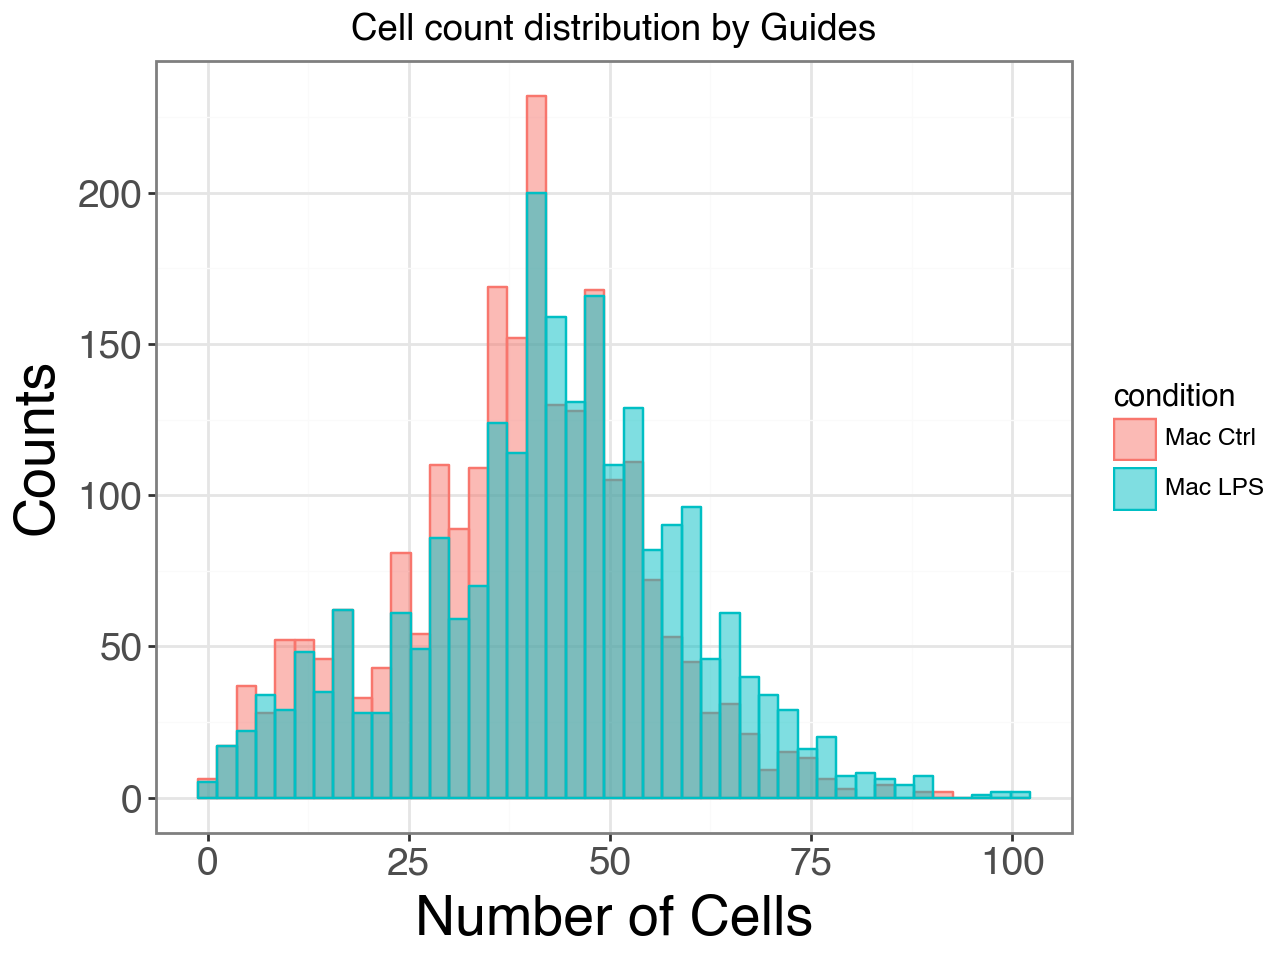

In [41]:
plt_path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/plots'
p = (ggplot(df_n_cells_guide, aes(x="n_cells", color  = 'condition', fill = 'condition')) 
+ geom_histogram(alpha=0.5, position="identity")
+ labs(title= 'Cell count distribution by Guides',
      x = 'Number of Cells',
      y = 'Counts')
+ theme_bw()
+ theme(
    axis_title_x=element_text(size=20),
    axis_title_y=element_text(size=20),
    axis_text_x=element_text(size=14),
    axis_text_y= element_text(size=14)
))
p.save(os.path.join(plt_path, 'cell_counts_distribution_singlets.png'), dpi = 150)
p.show()

### Get testable genes

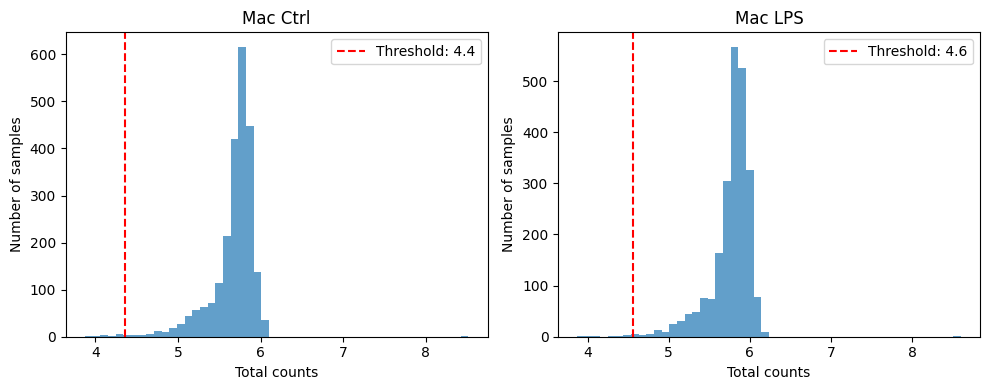

In [42]:
all_conditions = pbulk_adata.obs['condition'].unique() 
pbulk_adata.obs['total_counts'] = np.array(pbulk_adata.layers['sum'].sum(1)).flatten()

# Exclude samples with very low counts compared to others (threshold by condition)
tot_counts_lower_q = pbulk_adata.obs.groupby('condition')['total_counts'].quantile(0.005).to_dict()

# Plot histograms of total counts by condition with threshold lines
fig, axes = plt.subplots(1, len(all_conditions), figsize=(5*len(all_conditions), 4))
if len(all_conditions) == 1:
    axes = [axes]

for ax, condition in zip(axes, all_conditions):
    # Get data for this condition
    mask = pbulk_adata.obs['condition'] == condition
    counts = np.log10(pbulk_adata.obs.loc[mask, 'total_counts'])
    threshold = np.log10(tot_counts_lower_q[condition])
    
    # Plot histogram
    ax.hist(counts, bins=50, alpha=0.7)
    ax.axvline(threshold, color='red', linestyle='--', 
               label=f'Threshold: {threshold:.1f}')
    
    # Customize plot
    ax.set_title(f'{condition}')
    ax.set_xlabel('Total counts')
    ax.set_ylabel('Number of samples')
    ax.legend()
    
plt.tight_layout()
plt.show()

In [43]:
df_ctrl = pd.read_csv('/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/qc_stats/Macs_Ctrl_cell_level_guide_efficiency.csv')
df_ctrl['significant_ko'] = df_ctrl['adj_pvals']< 0.1
df_ctrl['condition'] = 'Mac_Ctrl'
df_ctrl['sample_id'] = df_ctrl[['condition', 'guide_id']].apply(lambda x: "_".join(x), axis=1)
df_no_effect_ctrl = df_ctrl[~df_ctrl['significant_ko']]
df_no_effect_ctrl

,guide_id,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc,guide_mean,ntc_mean,guide_var,...,ntc_std,fc,t_statistic,p_value,adj_pvals,effect_size,percent_cells_signi_ko,significant_ko,condition,sample_id
0,A4GALT-1,578,17.812806,15.402874,29628,564.380737,477.377357,0.030818,0.019049,0.025743,...,0.125499,0.854375,1.753066,1.000000,1.000000,0.093215,0.958478,False,Mac_Ctrl,Mac_Ctrl_A4GALT-1
1,A4GALT-2,390,13.338955,10.076600,29628,564.380737,477.377357,0.034202,0.019049,0.024731,...,0.125499,0.820034,1.895015,1.000000,1.000000,0.120303,0.948718,False,Mac_Ctrl,Mac_Ctrl_A4GALT-2
2,A4GALT-3,827,23.268857,18.793370,29628,564.380737,477.377357,0.028136,0.019049,0.021960,...,0.125499,0.883696,1.746158,1.000000,1.000000,0.072027,0.961306,False,Mac_Ctrl,Mac_Ctrl_A4GALT-3
3,A4GALT-4,951,19.837996,16.570582,29628,564.380737,477.377357,0.020860,0.019049,0.017007,...,0.125499,0.974439,0.422077,1.000000,1.000000,0.014414,0.972660,False,Mac_Ctrl,Mac_Ctrl_A4GALT-4
16,ACTL6A-1,889,306.701416,283.850639,29628,10177.830078,9556.352051,0.344996,0.343521,0.200495,...,0.452267,0.996265,0.096769,1.000000,1.000000,0.003263,0.573678,False,Mac_Ctrl,Mac_Ctrl_ACTL6A-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,ZNF79-3,1017,54.248056,41.702788,29628,1139.320648,881.889221,0.053341,0.038454,0.038198,...,0.168189,0.855943,2.398826,1.000000,1.000000,0.088004,0.923304,False,Mac_Ctrl,Mac_Ctrl_ZNF79-3
2164,ZNF79-4,645,19.992992,13.534191,29628,1139.320648,881.889221,0.030997,0.038454,0.020054,...,0.168189,1.092069,-1.317341,0.094083,0.146915,-0.044477,0.950388,False,Mac_Ctrl,Mac_Ctrl_ZNF79-4
2166,ZNF823-2,719,65.517632,47.691523,29628,2265.794250,1867.140106,0.091123,0.076475,0.058108,...,0.239109,0.896201,1.610338,1.000000,1.000000,0.061251,0.862309,False,Mac_Ctrl,Mac_Ctrl_ZNF823-2
2167,ZNF823-3,472,30.766777,24.420166,29628,2265.794250,1867.140106,0.065184,0.076475,0.047590,...,0.239109,1.098025,-1.113852,0.132945,0.201367,-0.047283,0.908898,False,Mac_Ctrl,Mac_Ctrl_ZNF823-3


In [44]:
df_lps = pd.read_csv('/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis/qc_stats/Macs_LPS_cell_level_guide_efficiency.csv')
df_lps['significant_ko'] = df_lps['adj_pvals']< 0.1
df_lps['condition'] = 'Mac_LPS'
df_lps['sample_id'] = df_lps[['condition', 'guide_id']].apply(lambda x: "_".join(x), axis=1)
df_no_effect_lps = df_lps[~df_lps['significant_ko']]
df_no_effect_lps

,guide_id,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc,guide_mean,ntc_mean,guide_var,...,ntc_std,fc,t_statistic,p_value,adj_pvals,effect_size,percent_cells_signi_ko,significant_ko,condition,sample_id
1,A4GALT-2,416,83.572794,83.632089,33146,7415.184814,7427.030273,0.200896,0.223713,0.161067,...,0.417167,1.090941,-1.151785,0.125027,0.193565,-0.054720,0.762019,False,Mac_LPS,Mac_LPS_A4GALT-2
2,A4GALT-3,1060,248.192352,243.806694,33146,7415.184814,7427.030273,0.234144,0.223713,0.175348,...,0.417167,0.963290,0.798435,1.000000,1.000000,0.025001,0.723585,False,Mac_LPS,Mac_LPS_A4GALT-3
16,ACTL6A-1,1004,347.464966,317.427750,33146,11648.007324,11101.845459,0.346081,0.351415,0.196587,...,0.459839,1.013468,-0.375166,0.353806,0.488482,-0.011613,0.573705,False,Mac_LPS,Mac_LPS_ACTL6A-1
23,ACVR1B-4,1292,758.656464,830.519745,33146,20122.969727,22836.793457,0.587195,0.607101,0.298250,...,0.566051,1.031239,-1.283537,0.099758,0.156907,-0.035211,0.386997,False,Mac_LPS,Mac_LPS_ACVR1B-4
24,ADCY4-1,565,4.520184,3.814471,33146,276.983955,220.114586,0.008000,0.008356,0.006699,...,0.081062,1.006141,-0.102578,0.459167,0.599598,-0.004393,0.989381,False,Mac_LPS,Mac_LPS_ADCY4-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,ZNF79-3,1247,55.327368,40.605597,33146,1104.591644,864.881454,0.044368,0.033325,0.030619,...,0.158061,0.882976,2.195206,1.000000,1.000000,0.069584,0.930233,False,Mac_LPS,Mac_LPS_ZNF79-3
2165,ZNF823-1,910,33.340771,27.321822,33146,1333.877625,1084.952240,0.036638,0.040242,0.028713,...,0.176392,1.041602,-0.632314,0.263666,0.376988,-0.020454,0.947253,False,Mac_LPS,Mac_LPS_ZNF823-1
2166,ZNF823-2,905,45.083932,37.499981,33146,1333.877625,1084.952240,0.049816,0.040242,0.038998,...,0.176392,0.904084,1.442840,1.000000,1.000000,0.054095,0.930387,False,Mac_LPS,Mac_LPS_ZNF823-2
2167,ZNF823-3,539,18.386708,12.264172,33146,1333.877625,1084.952240,0.034113,0.040242,0.021630,...,0.176392,1.072877,-0.956523,0.169609,0.254414,-0.034836,0.944341,False,Mac_LPS,Mac_LPS_ZNF823-3


In [45]:
df = pd.concat([df_no_effect_ctrl, df_no_effect_lps], axis=0)
df

,guide_id,n_cells,sum_guide,sumsq_guide,ntc_cells,sum_ntc,sumsq_ntc,guide_mean,ntc_mean,guide_var,...,ntc_std,fc,t_statistic,p_value,adj_pvals,effect_size,percent_cells_signi_ko,significant_ko,condition,sample_id
0,A4GALT-1,578,17.812806,15.402874,29628,564.380737,477.377357,0.030818,0.019049,0.025743,...,0.125499,0.854375,1.753066,1.000000,1.000000,0.093215,0.958478,False,Mac_Ctrl,Mac_Ctrl_A4GALT-1
1,A4GALT-2,390,13.338955,10.076600,29628,564.380737,477.377357,0.034202,0.019049,0.024731,...,0.125499,0.820034,1.895015,1.000000,1.000000,0.120303,0.948718,False,Mac_Ctrl,Mac_Ctrl_A4GALT-2
2,A4GALT-3,827,23.268857,18.793370,29628,564.380737,477.377357,0.028136,0.019049,0.021960,...,0.125499,0.883696,1.746158,1.000000,1.000000,0.072027,0.961306,False,Mac_Ctrl,Mac_Ctrl_A4GALT-3
3,A4GALT-4,951,19.837996,16.570582,29628,564.380737,477.377357,0.020860,0.019049,0.017007,...,0.125499,0.974439,0.422077,1.000000,1.000000,0.014414,0.972660,False,Mac_Ctrl,Mac_Ctrl_A4GALT-4
16,ACTL6A-1,889,306.701416,283.850639,29628,10177.830078,9556.352051,0.344996,0.343521,0.200495,...,0.452267,0.996265,0.096769,1.000000,1.000000,0.003263,0.573678,False,Mac_Ctrl,Mac_Ctrl_ACTL6A-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2163,ZNF79-3,1247,55.327368,40.605597,33146,1104.591644,864.881454,0.044368,0.033325,0.030619,...,0.158061,0.882976,2.195206,1.000000,1.000000,0.069584,0.930233,False,Mac_LPS,Mac_LPS_ZNF79-3
2165,ZNF823-1,910,33.340771,27.321822,33146,1333.877625,1084.952240,0.036638,0.040242,0.028713,...,0.176392,1.041602,-0.632314,0.263666,0.376988,-0.020454,0.947253,False,Mac_LPS,Mac_LPS_ZNF823-1
2166,ZNF823-2,905,45.083932,37.499981,33146,1333.877625,1084.952240,0.049816,0.040242,0.038998,...,0.176392,0.904084,1.442840,1.000000,1.000000,0.054095,0.930387,False,Mac_LPS,Mac_LPS_ZNF823-2
2167,ZNF823-3,539,18.386708,12.264172,33146,1333.877625,1084.952240,0.034113,0.040242,0.021630,...,0.176392,1.072877,-0.956523,0.169609,0.254414,-0.034836,0.944341,False,Mac_LPS,Mac_LPS_ZNF823-3


In [46]:
# Load info on perturbed genes to test
# Create separate boolean columns for each filtering condition
pbulk_adata.obs['keep_min_cells'] = pbulk_adata.obs['n_cells'] >= 5  # Mark guides with at least n cells per condition & sample
pbulk_adata.obs['keep_effective_guides'] = ~pbulk_adata.obs['sample_id'].isin(df.sample_id)  # Don't count ineffective guides as useful replicates

# Filter counts outliers
pbulk_adata.obs['keep_total_counts'] = True  # Initialize as all True
for c, thresh in tot_counts_lower_q.items():
    mask = pbulk_adata.obs['condition'] == c
    pbulk_adata.obs.loc[mask, 'keep_total_counts'] = pbulk_adata.obs.loc[mask, 'total_counts'] >= thresh

# Combine all conditions into a single keep_for_DE column
pbulk_adata.obs['keep_for_DE'] = (
    pbulk_adata.obs['keep_min_cells'] & 
    pbulk_adata.obs['keep_effective_guides'] & 
    pbulk_adata.obs['keep_total_counts']
)

In [ ]:
pbulk_adata.obs_keys

In [47]:
guide_cell_counts = pbulk_adata.obs[['guide_id', 'target_gene', 'condition', 'n_cells', 'keep_for_DE']]
guide_cell_counts = guide_cell_counts[~guide_cell_counts['guide_id'].str.startswith('NTC-')] 

# Count number of replicates per perturbed gene in each condition
genes_replicates = guide_cell_counts.groupby(['target_gene', 'condition'])['keep_for_DE'].sum()\
    .sort_values()\
    .reset_index()\
    .pivot(index='target_gene', columns='condition', values='keep_for_DE')\
    .fillna(0)

genes2test = genes_replicates >= 3
genes2test_dict = {col: genes2test.index[genes2test[col]].tolist() for col in genes2test.columns}
for c in genes2test_dict.keys():
    print(c, ':', len(genes2test_dict[c]))

Mac Ctrl : 342
Mac LPS : 334


## Filter samples for DE analysis

In [48]:
# Keep genes that pass filters for each condition separately
pbulk_adata.obs['keep_test_genes'] = False  # Initialize as all False

# For each condition, mark genes that pass filters for that condition
for condition, genes in genes2test_dict.items():
    mask = (pbulk_adata.obs['condition'] == condition) & \
           (pbulk_adata.obs['target_gene'].isin(genes))
    pbulk_adata.obs.loc[mask, 'keep_test_genes'] = True

# Always keep NTC samples
pbulk_adata.obs.loc[pbulk_adata.obs['target_gene'] == 'NTC', 'keep_test_genes'] = True

# Aggregate with the existing keep_for_DE condition
pbulk_adata.obs['keep_for_DE'] = pbulk_adata.obs['keep_for_DE'] & pbulk_adata.obs['keep_test_genes']

pbulk_adata.obs['keep_for_DE'].value_counts()

keep_for_DE
True     2576
False    2061
Name: count, dtype: int64

In [49]:
pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].copy()

In [51]:
# pbulk_adata = pbulk_adata.copy()
pbulk_adata.X = sparse.csc_matrix(pbulk_adata.layers['sum'])
del pbulk_adata.layers['sum']
pbulk_adata.obs['log10_n_cells'] = np.log10(pbulk_adata.obs['n_cells'])
pbulk_adata.write_h5ad(os.path.join(path, 'MACS_DE_pseudobulk_for_test.h5ad'))

In [ ]:
# try:
#     pbulk_adata
# except NameError:
#     pbulk_adata = sc.read_h5ad(f'{datadir}/{pseudobulk_file}')
# pbulk_adata = pbulk_adata[pbulk_adata.obs['keep_for_DE']].copy()

In [ ]:
# genes_of_interest = [
#     'NLRC3',
#     'USP8', 
#     'SART1',
#     'JAK3',
#     'IKBKG',
#     'GIMAP1',
#     'VCP',
#     'IL2RG',
#     'MAP2K7',
#     'JAK1',
#     'MAP3K7',
#     'BECN1',
#     'SOCS3',
#     'ILF2',
#     'PRMT1'
# ]

# g = genes_of_interest[2]
# check_df = pbulk_adata.obs[pbulk_adata.obs['perturbed_gene_name'].isin(genes_of_interest)]
# check_df['perturbed_gene_name'] = check_df['perturbed_gene_name'].astype(str)
# check_df.groupby(['perturbed_gene_name', 'culture_condition'])['n_cells'].sum().reset_index().pivot(columns='culture_condition', index='perturbed_gene_name')

## Feature selection

In [115]:
path = '/Users/chandrima.modak/Gladstone Dropbox/Chandrima Modak/macs_perturbseq_analysis'
pbulk_adata= sc.read_h5ad(os.path.join(path, 'MACS_DE_pseudobulk_for_test.h5ad'))
pbulk_adata

AnnData object with n_obs × n_vars = 2576 × 18129
    obs: 'sample_id', 'condition', 'guide_id', 'target_gene', 'n_cells', 'total_counts', 'keep_min_cells', 'keep_effective_guides', 'keep_total_counts', 'keep_for_DE', 'keep_test_genes', 'log10_n_cells'
    var: 'gene_ids', 'gene_name'

In [116]:
def feature_selection(adata, 
                      n_hvgs = 5000, 
                      filter_ribo_mito = True, 
                      subset_adata =False, 
                      highx_min_mean_counts = 1000,
                     highx_min_pct_dropouts_by_counts  = 0.5,
                     lowx_min_counts = 1,
                     lowx_max_pct_dropouts_by_counts = 99.9,
                     return_all = False):
    if filter_ribo_mito:
        filter_genes = adata.var_names[adata.var_names.str.startswith('MT-')].tolist()

    if subset_adata:
        adata_sb = sc.pp.sample(adata, fraction=0.1, copy=True)
    else:
        adata_sb = adata.copy()
        
    sc.pp.calculate_qc_metrics(adata_sb, inplace=True)

     # Filter out highly and lowly expressed outlier genes
    highly_expressed_outliers = adata_sb.var_names[(adata_sb.var['mean_counts'] > highx_min_mean_counts) & (adata_sb.var['pct_dropout_by_counts'] < highx_min_pct_dropouts_by_counts)].tolist()
    lowly_expressed_outliers = adata_sb.var_names[(adata_sb.var['total_counts'] < lowx_min_counts) & (adata_sb.var['pct_dropout_by_counts'] > lowx_max_pct_dropouts_by_counts)].tolist()
    filter_genes.extend(highly_expressed_outliers)
    filter_genes.extend(lowly_expressed_outliers)

    # Subset
    adata_sb = adata_sb[:, ~adata_sb.var_names.isin(filter_genes)].copy()

    sc.pp.highly_variable_genes(adata_sb, n_top_genes=n_hvgs, flavor='seurat_v3')
    
    if return_all:
        hvg_df = adata_sb.var.copy()
    else:
        hvg_df = adata_sb.var[adata.var['highly_variable']][['gene_name', 'gene_ids']]
    
    return(hvg_df)

    

In [117]:
feature_selection_vars = pd.DataFrame()
for c in pbulk_adata.obs['condition'].unique():
    print(c)
    pbulk_adata_cond = pbulk_adata[pbulk_adata.obs['condition'] == c].copy()
    feature_selection_var = feature_selection(
        pbulk_adata_cond,
        n_hvgs = 10000,
        subset_adata=False,
        highx_min_mean_counts = 10000,
        highx_min_pct_dropouts_by_counts = 0.9,
        lowx_max_pct_dropouts_by_counts = 99.9,
        lowx_min_counts = 1,
        return_all = True
        )

    all_targets = pbulk_adata_cond.obs['target_gene'].unique()
    feature_selection_var['is_target'] = feature_selection_var.index.isin(all_targets)

    DE_test_genes = feature_selection_var[feature_selection_var['highly_variable'] | feature_selection_var['is_target']].index.tolist()
    # Save DE_test_genes to a text file
    with open(f"{path}/de_test_genes_file.txt", 'w') as f:
        for gene in DE_test_genes:
            f.write(f"{gene}\n")
    feature_selection_var['condition'] = c
    feature_selection_vars = pd.concat([feature_selection_vars, feature_selection_var])

Mac Ctrl
Mac LPS


In [108]:
feature_selection_vars.to_csv(f"{path}/DE_feature_selection_vars.csv")
pbulk_adata.obs.to_csv(f"{path}/DE_obs.csv")

In [119]:
feature_selection_vars

,gene_ids,gene_name,n_cells_by_counts,mean_counts,log1p_mean_counts,pct_dropout_by_counts,total_counts,log1p_total_counts,highly_variable,highly_variable_rank,means,variances,variances_norm,is_target,condition
SAMD11,ENSG00000187634,SAMD11,5,0.003846,0.003839,99.615385,5.0,1.791759,False,NaN,0.003846,3.834310e-03,0.696990,False,Mac Ctrl
NOC2L,ENSG00000188976,NOC2L,1253,7.090769,2.090724,3.615385,9218.0,9.129022,True,3088.0,7.090769,6.653793e+03,1.002885,False,Mac Ctrl
KLHL17,ENSG00000187961,KLHL17,627,1.006923,0.696603,51.769231,1309.0,7.177782,False,NaN,1.006923,1.277498e+02,0.975227,False,Mac Ctrl
PLEKHN1,ENSG00000187583,PLEKHN1,573,0.962308,0.674121,55.923077,1251.0,7.132498,True,1984.0,0.962308,1.241010e+02,1.008339,False,Mac Ctrl
PERM1,ENSG00000187642,PERM1,7,0.006154,0.006135,99.461538,8.0,2.197225,False,NaN,0.006154,7.660330e-03,0.714209,False,Mac Ctrl
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TMSB4Y,ENSG00000154620,TMSB4Y,877,1.849530,1.047154,31.269592,2360.0,7.766841,False,NaN,1.849530,4.131664e+02,0.936328,False,Mac LPS
NLGN4Y,ENSG00000165246,NLGN4Y,12,0.010188,0.010137,99.059561,13.0,2.639057,False,NaN,0.010188,1.166083e-02,0.505055,False,Mac LPS
TTTY14,ENSG00000176728,TTTY14,17,0.022727,0.022473,98.667712,29.0,3.401197,True,604.0,0.022727,1.445811e-01,1.144721,False,Mac LPS
KDM5D,ENSG00000012817,KDM5D,1276,45.059561,3.829935,0.000000,57496.0,10.959488,False,NaN,45.059561,2.576306e+05,0.980224,False,Mac LPS


In [ ]:
# df = pd.read_csv(f"{datadir}/DE_obs.csv", index_col=0)
# df[df.perturbed_gene_name == 'SOCS3']

In [ ]:
# pbulk_adata.obs['guide_id']

In [ ]:
## --- SPLIT PERTURBATIONS INTO CHUNKS --- ##
# for c in pbulk_adata.obs['culture_condition'].unique():
#     print(c)
#     pbulk_adata_cond = pbulk_adata[pbulk_adata.obs['culture_condition'] == c].copy()
#     all_targets = pbulk_adata_cond.obs['perturbed_gene_id'].unique().tolist()
#     all_targets.remove('NTC')

#     # Randomize targets before splitting (without replacement)
#     np.random.seed(chunk_split_seed)
#     np.random.shuffle(all_targets)

#     # Split all_targets into groups based on chunk_size
#     target_chunks = [all_targets[i:i+chunk_size] for i in range(0, len(all_targets), chunk_size)]

#     # Initialize a binary matrix with zeros
#     target_chunk_matrix = pd.DataFrame(0, 
#                                     index=all_targets, 
#                                     columns=[f'chunk_{i}' for i in range(len(target_chunks))])

#     # Fill the matrix with 1s for each target in its respective chunk
#     for chunk_idx, chunk in enumerate(target_chunks):
#         target_chunk_matrix.loc[chunk, f'chunk_{chunk_idx}'] = 1

#     target_chunk_matrix.to_csv(f"{datadir}/{target2chunk_file.replace('.csv.gz', f'.{c}.csv.gz')}", compression='gzip')